# Actor Critic
This notebook trains an agent using current state-of-the-art algorithm SAC which is similar to DDPG and TD3. SAC is an off-policy actor-critic RL method, which maximizes an objective with **entropy regularization**: $J = J_θ + α H(π_θ)$, where $J_θ$ is the expected return with respect to the parameters $\theta$ of our policy, which we typically maximize, $H$ is the entropy and $\alpha$ is a hyperparameter to balance it. 

The agent will solve the LunarLander environment from Gymnasium to safely land a vehicle on the surface on the moon.

<img src="resources/lunar_lander.gif" alt="Gymnasium" width="20%"/>

<!--  -->
_Agent using random actions to land the lunarlander_

In [1]:
!pip install gymnasium

In [2]:
# Imports
from typing import Iterable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## Critic
Define Critic network which will estimate the expected cumulative reward.

In [3]:
class Critic(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int):
        """
        Initialize the Critic network.
        
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()


    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, action], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out


## Actor 
Definition of the Actor network. In contrast to DDPG, SAC uses a stochastic policy. This means that the actor outputs a probability distribution over the actions. The distribution is parameterized by a mean $\mu$ and a standard deviation $\sigma$. Typically, the stochastic policy is modeled with a squashed diagonal Gaussian distribution. The squashing function is used to ensure that the actions are within the bounds of the environment's action space.

### Reparameterization Trick
The reason for using a stochastic policy is to allow exploration. However, the stochasticity (sampling directly from $\mathcal{N}(\mu(s), \sigma(s))$) makes it difficult to compute the gradients of the loss function. This is where the reparameterization trick comes in. The trick is to sample the action from a deterministic distribution ($\mu(s)$ and $\sigma(s)$) and then add noise ($\mathcal{N}(0, \mathcal{I})$). This way, the gradients can be computed with respect to the deterministic distribution, while the actions are still sampled from the stochastic distribution.

$$
a \sim \mathcal{N}(\mu(s), \sigma(s)) => \mu(s) + \sigma(s) \cdot \mathcal{N}(0, \mathcal{I})
$$


In [4]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, action_low: np.array, action_high: np.array):
        """
        Initialize the Actor network.
        
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Actor, self).__init__()
        # We are registering scale and bias as buffers so they can be saved and loaded as part of the model.
        # Buffers won't be passed to the optimizer for training!
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32)
        )
        
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc_mu = nn.Linear(256, action_dim)
        logstds_param = nn.Parameter(torch.full((action_dim,), -69*1e-2))
        self.register_parameter("logstds", logstds_param)
        # self.fc_std = nn.Linear(256, action_dim)

    def forward(self, obs: torch.Tensor) -> "tuple[torch.Tensor, torch.Tensor]":
        """
        Forward pass of the actor network.
        
        return: mean_action, log_prob_action
        """
        x = F.relu(self.fc1(obs))
        mu = self.fc_mu(x)
        std = torch.clamp(self.logstds.exp(), 1e-3, 1.0)
        dist = torch.distributions.Normal(mu, std)

        action = dist.rsample()
        log_prob = dist.log_prob(action)

        # Enforcing action bounds
        adjusted_action = torch.tanh(action) * self.action_scale + self.action_bias
        adjusted_log_prob = log_prob - torch.log(self.action_scale * (1-torch.tanh(action).pow(2)) + 1e-6)
        return adjusted_action, adjusted_log_prob
        


In [12]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Check if GPU is available and set PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
alpha = 1e-4  # step size for actor
beta = 0.01   # step size for critic
gamma = 0.99  # discount factor

# Initialize environment
env = gym.make("LunarLander-v2", continuous=True, gravity=-10.0, render_mode="rgb_array")
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_low = env.action_space.low
action_high = env.action_space.high

# Initialize networks and move them to the device
actor = Actor(obs_dim, action_dim, action_low, action_high).to(device)
critic = Critic(obs_dim, action_dim).to(device)

# Initialize optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=alpha)
critic_optimizer = optim.Adam(critic.parameters(), lr=beta)

# Training loop
num_episodes = 200
average_rewards = []
all_rewards = []
all_trajectory_lengths = []
all_actor_losses = []
all_critic_losses = []

for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    I = 1  # Initialize eligibility trace

    rewards = []
    actor_losses = []
    critic_losses = []

    while not done:
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        
        action, log_prob = actor(obs_tensor)
        action = action.detach().cpu().numpy()[0]
        log_prob = log_prob.sum(-1)
        
        next_obs, reward, done, truncated, _ = env.step(action)
        rewards.append(reward)
        
        next_obs_tensor = torch.tensor(next_obs, dtype=torch.float32).unsqueeze(0).to(device)
        action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0).to(device)
        reward_tensor = torch.tensor(reward, dtype=torch.float32).unsqueeze(0).to(device)
        
        value = critic(obs_tensor, action_tensor)
        next_value = critic(next_obs_tensor, torch.zeros_like(action_tensor)) if not done else torch.tensor(0.0, device=device)
        delta = reward_tensor + gamma * next_value - value

        critic_loss = F.mse_loss(reward_tensor + gamma * next_value, value)
        critic_losses.append(critic_loss.item())
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        actor_loss = -log_prob * delta.detach()
        actor_losses.append(actor_loss.item())
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        obs = next_obs
        I = gamma * I  # Update eligibility trace


    episode_reward = np.sum(rewards)
    average_rewards.append(episode_reward)
    all_rewards.append(episode_reward)
    all_actor_losses.append(np.mean(actor_losses))
    all_critic_losses.append(np.mean(critic_losses))

    all_trajectory_lengths.append(len(rewards))
    # print(next(actor.parameters()))
    if (episode+1) % 100 == 0 or episode == 0:
        # print(f"Episode {episode + 1}, Actor: {np.mean(actor_losses):.2f}, Critic: {np.mean(critic_losses):.2f}, reward: {episode_reward}, Trajectory Length: {len(rewards)}")
        print(f"Episode {episode + 1}, Last 200 episodes average reward: {np.mean(average_rewards[-200:]):.2f}")

        # Save actor
        torch.save(actor, f"./checkpoints/actor_ac_ep_{episode}.pt")

env.close()
torch.save(actor, "./checkpoints/actor_ac_last.pt")




/tmp/ipykernel_29955/4055320954.py:67: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(reward_tensor + gamma * next_value, value)


Episode 1, Last 200 episodes average reward: -49.62
Episode 100, Last 200 episodes average reward: -231.47
Episode 200, Last 200 episodes average reward: -313.09


In [13]:
# Save data
import pandas as pd

all_results = {
    "rewards": all_rewards,
    "actor_losses": all_actor_losses,
    "critic_losses": all_critic_losses,
    "trajectory_lengths": all_trajectory_lengths
}

df = pd.DataFrame(all_results)
df.to_csv('results.csv')

In [14]:
loaded_actor = torch.load("./checkpoints/actor_ac_last.pt")
loaded_actor.eval()
print(loaded_actor)

Actor(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
)


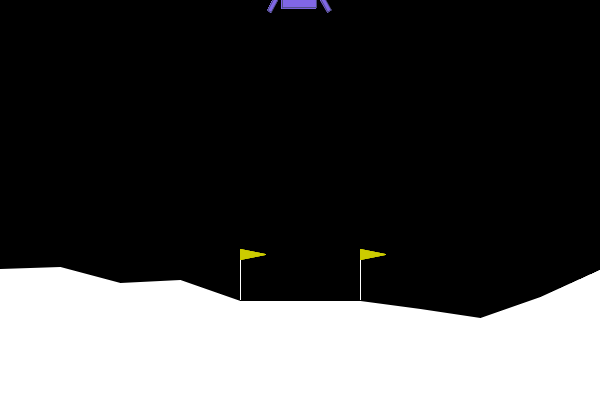

In [15]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32))[0].cpu().numpy()
            
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

imgs = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")